In [1]:
import os
import json
import pandas as pd
import re

def parse_filename(filename):
    pattern = r"experiment_(\w+)_(\d+)_(\d+)_([A-Z]+)_(\d{8})_(\d{6})"
    match = re.match(pattern, filename.replace('.json', ''))
    if match:
        algo, short, long, stock, date, time = match.groups()
        parsed = {
            "Algorithm": algo,
            "Short Window": int(short),
            "Long Window": int(long),
            "Stock": stock,
            "Date": f"{date[:4]}-{date[4:6]}-{date[6:]}",
            "Time": f"{time[:2]}:{time[2:4]}:{time[4:]}"
        }
        return parsed
    else:
        return {}

# Directory with JSON files
data_dir = '.'
data = []

for filename in os.listdir(data_dir):
    if filename.endswith('.json'):
        with open(os.path.join(data_dir, filename), 'r') as f:
            metrics = json.load(f)
            meta = parse_filename(filename)
            metrics.update(meta)
            metrics["File"] = filename
            data.append(metrics)

# Create DataFrame
df = pd.DataFrame(data)

# Optional: set a composite index if useful
df.set_index(['Algorithm', 'Short Window', 'Long Window', 'Stock', 'Date', 'Time'], inplace=True)

print(df.head())


                                                              Sharpe Ratio  \
Algorithm Short Window Long Window Stock Date       Time                     
SMA       20           50          BTC   2025-07-07 03:20:38        0.3272   
                                         2025-07-08 01:44:36        0.2411   

                                                              Sortino Ratio  \
Algorithm Short Window Long Window Stock Date       Time                      
SMA       20           50          BTC   2025-07-07 03:20:38         0.0600   
                                         2025-07-08 01:44:36         0.0419   

                                                              Max Drawdown  \
Algorithm Short Window Long Window Stock Date       Time                     
SMA       20           50          BTC   2025-07-07 03:20:38        -0.014   
                                         2025-07-08 01:44:36        -0.014   

                                                         

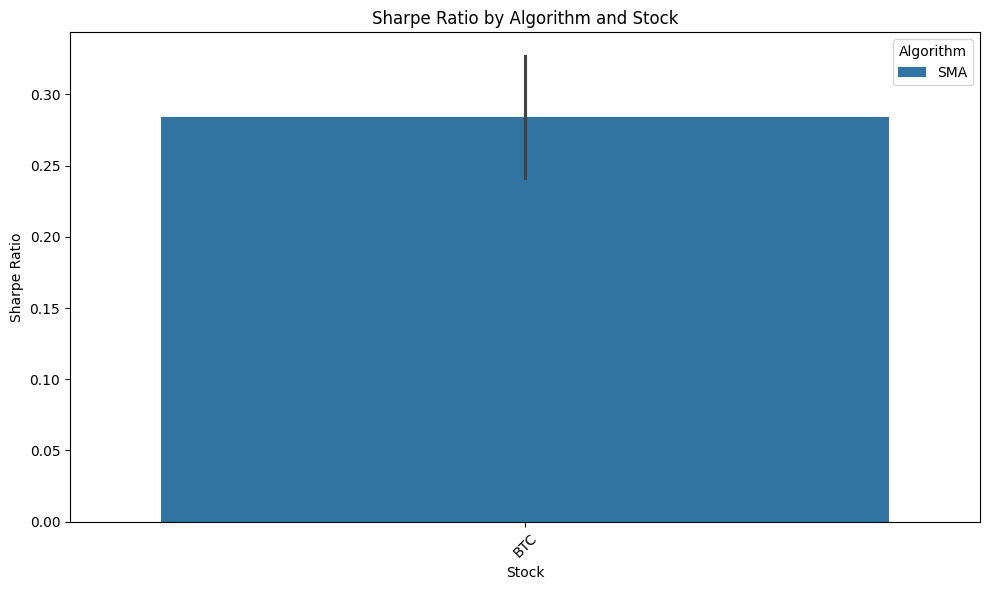

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df_reset = df.reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_reset,
    x="Stock",
    y="Sharpe Ratio",
    hue="Algorithm"
)
plt.title("Sharpe Ratio by Algorithm and Stock")
plt.ylabel("Sharpe Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


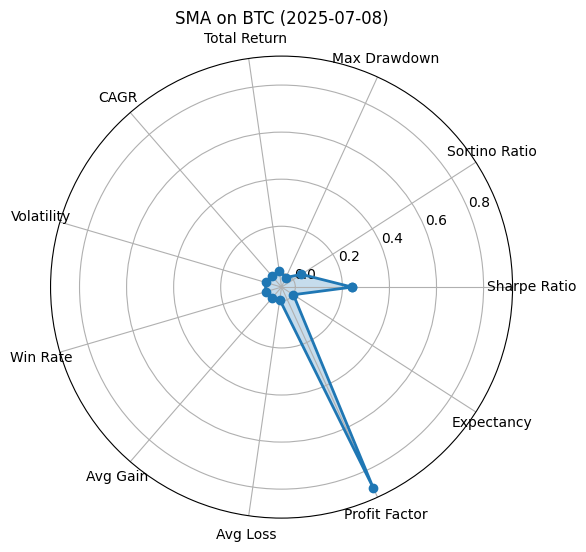

In [3]:
import numpy as np
def plot_radar_chart(df_row, title):
    labels = df_row.index
    values = df_row.values

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))  # Close the loop
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title)
    ax.grid(True)
    plt.show()

# Select all numeric columns
metric_cols = [
    'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Total Return',
    'CAGR', 'Volatility', 'Win Rate', 'Avg Gain', 'Avg Loss',
    'Profit Factor', 'Expectancy'
]

# Example: Plot radar chart for each stock using most recent experiment
for stock in df_reset['Stock'].unique():
    sub_df = df_reset[df_reset['Stock'] == stock]
    latest = sub_df.sort_values(by='Date', ascending=False).iloc[0]
    plot_radar_chart(latest[metric_cols], f"{latest['Algorithm']} on {stock} ({latest['Date']})")
